# filter temporally surface fields and geographically average energies


In [1]:
import os

import numpy as np
import xarray as xr
import pandas as pd

from scipy import signal

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

import mitequinox.utils as ut
import mitequinox.plot as pl
import mitequinox.sigp as sp

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=15) # heavier data processing
    #w = cluster.scale(jobs=10)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: http://10.148.0.234:8787/status,
Dashboard: http://10.148.0.234:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.234:34226,Workers: 0
Dashboard: http://10.148.0.234:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---

## define the filter and utils

In [4]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1")
omega, domega, name = tidal_omega["M2"], .2, "semidiurnal"
T=10

h = sp.generate_filter(omega, T=T, dt=dt, bandwidth=domega, normalized_bandwidth=None)
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


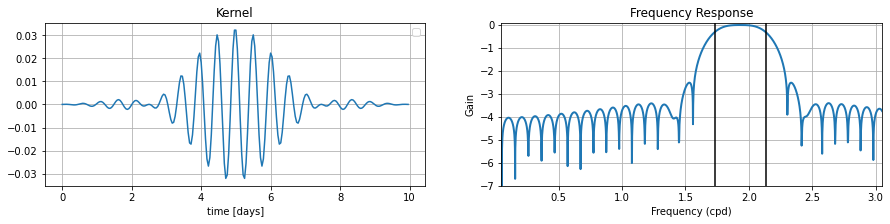

In [5]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
t = np.arange(0, h.size)*dt
ax.plot(t, h)
ax.grid()
ax.set_xlabel("time [days]")
ax.set_title("Kernel")
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-domega, color="k")
ax.axvline(omega+domega, color="k")
ax.set_xlabel("Frequency (cpd)")
ax.set_ylabel("Gain")
ax.set_title("Frequency Response")
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [6]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode="constant")
    x_f = signal.filtfilt(h, [1], x, axis=-1)
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False, subsample=1):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={"time": len(v.time)})
    out = xr.apply_ufunc(convolve, v, 
                    kwargs={"h": h, "hilbert": hilbert},
                    dask="parallelized", output_dtypes=[output_dtype],
                    input_core_dims=[["time"]],
                    output_core_dims=[["time"]],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )
    out = out.isel(time=slice(0, None, subsample))
    return out

---

## process full dataset and store

In [7]:
def load_rechunked(v, grid=True, dij=None):
    zarr = os.path.join(ut.work_data_dir, "rechunked/{}.zarr".format(v))
    ds = xr.open_zarr(zarr).chunk({"time": -1})
    if v=="SSU":
        ds = ds.rename({"i_g": "i"})
    elif v=="SSV":
        ds = ds.rename({"j_g": "j"})
    #
    if dij is not None:
        ds = ds.isel(i=slice(0,None, dij), j=slice(0,None, dij))
    #
    if grid:
        grd = ut.load_grd()[["XC", "YC", "Depth"]]
        ds = ds.merge(grd, join="inner")
    return ds

In [10]:
def filt_fun(da, name=None, absolute=False, omega=None):
    # should not take abs and subsamble to 12h (at least), not 24h
    # this is to estimate the lag properly
    out = filt(da, h, hilbert=True, subsample=12)
    if omega:
        # compute time interval with respect to reference
        t = ( out.time - pd.Timestamp("2010-01-01").to_datetime64() )/pd.Timedelta("1D") 
        out = out * np.exp(-1j*2*np.pi*omega*t)
    if absolute:
        out = abs(out)
    if name is None:
        name = da.name
    return out.rename(name)


for v in ["Eta", "SSU", "SSV"]:
    
    ds = load_rechunked(v, dij=2)
    ds_hat, Z = ut.custom_distribute(ds[v], filt_fun, 
                                     op_kwargs=dict(omega=omega),
                                     face=3)
    
    #ds_hat.to_zarr(os.path.join(ut.scratch, "".format(v)), mode="w")
    ut.store_diagnostic("bpassed_{}_{}".format(name, v), ds_hat, overwrite=True)

data stored in /home/datawork-lops-osi/equinox/mit4320/diags/bpassed_semidiurnal_abs_Eta.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/bpassed_semidiurnal_abs_SSU.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/bpassed_semidiurnal_abs_SSV.zarr


---

## load and (time/bin) average

In [7]:
V = ["Eta", "SSU", "SSV"]

ds = xr.merge([ut.load_diagnostic("bpassed_{}_{}".format(name, v)) for v in V])
ds = ds.isel(time=slice(T,-T))

depth_threshold = 500

mask_deep = (ds.Depth>depth_threshold).persist()
mask_shallow = (ds.Depth<depth_threshold).persist()

A_deep = ds.rA.where(mask_deep).mean(["face", "i", "j"]).compute()
A_shallow = ds.rA.where(mask_shallow).mean(["face", "i", "j"]).compute()

In [8]:
for v in ds:
    # multiply by 0.5 because Eta is the demodulated complex amplitude
    ds[v+"_square"] = 0.5*abs(ds[v])**2
    
#ds = ds.drop_vars(V)

---

### temporal average

In [33]:
mean = ds.mean("time").persist()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as

{'fig': <Figure size 1080x1080 with 2 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2aac033b8100>}

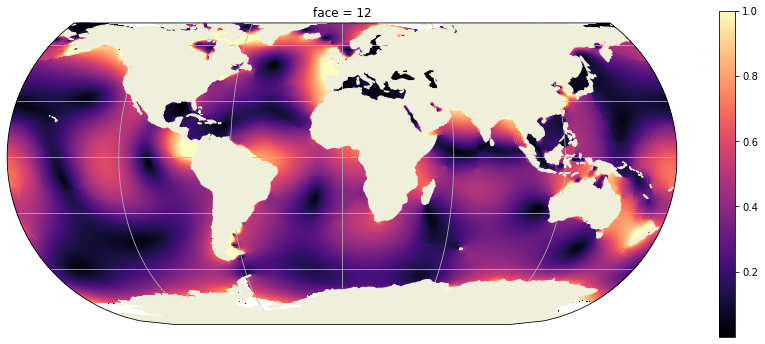

In [34]:
pl.plot_pretty(np.sqrt(mean["Eta_square"]), vmax=1., colorbar=True, colorbar_kwargs=dict(shrink=0.4))

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as

{'fig': <Figure size 1080x1080 with 2 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2aabe614dd60>}

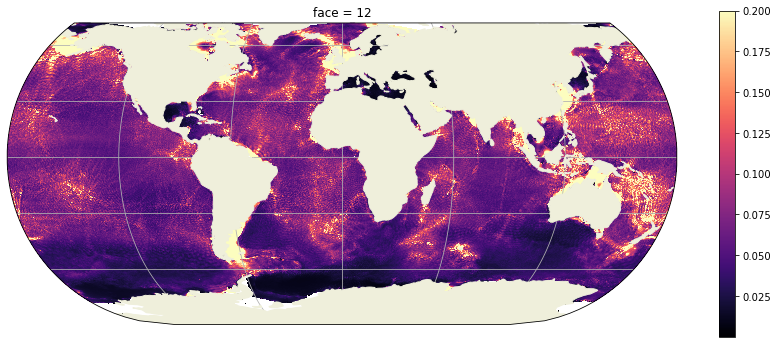

In [35]:
U = mean["SSU_square"]+mean["SSV_square"]
pl.plot_pretty(np.sqrt(U), vmax=.2, colorbar=True, colorbar_kwargs=dict(shrink=0.4))

Global averages

In [36]:
mean_deep = dict(Eta=(mean["Eta_square"]*ds.rA).where(mask_deep) \
                 .mean(["face", "i", "j"]).persist() /A_deep,
                 U=((mean["SSU_square"]+mean["SSV_square"])*ds.rA).where(mask_deep) \
                 .mean(["face", "i", "j"]).persist() /A_shallow,
           )

In [37]:
mean_shallow = dict(Eta=(mean["Eta_square"]*ds.rA).where(mask_shallow) \
                    .mean(["face", "i", "j"]).persist() /A_deep,
                    U=((mean["SSU_square"]+mean["SSV_square"])*ds.rA).where(mask_shallow) \
                    .mean(["face", "i", "j"]).persist() /A_shallow,
                   )

In [38]:
print("mean_deep Eta={:.3f} U={:.3f} ".format(float(mean_deep["Eta"]), float(np.sqrt(mean_deep["U"]))))
print("mean_shallow Eta={:.3f} U={:.3f} ".format(float(mean_shallow["Eta"]), float(np.sqrt(mean_shallow["U"]))))

mean_deep Eta=0.151 U=0.105 
mean_shallow Eta=0.395 U=0.379 


In [39]:
del mean_deep, mean_shallow
# not doing puch it seems

---

## individual locations

In [78]:
def get_index(lon, lat, ds):
    # https://en.wikipedia.org/wiki/Great-circle_distance
    _lat, _lon = ds.YC, ds.XC
    d2r = np.pi/180.
    dl = np.arccos( np.sin(_lat*d2r) * np.sin(lat*d2r) 
                   + np.cos(_lat*d2r) * np.cos(lat*d2r) * np.cos((_lon-lon)*d2r)
                  )
    index = dl.argmin(dim=("i", "j", "face"))
    return {i: v.compute() for i, v in index.items()}

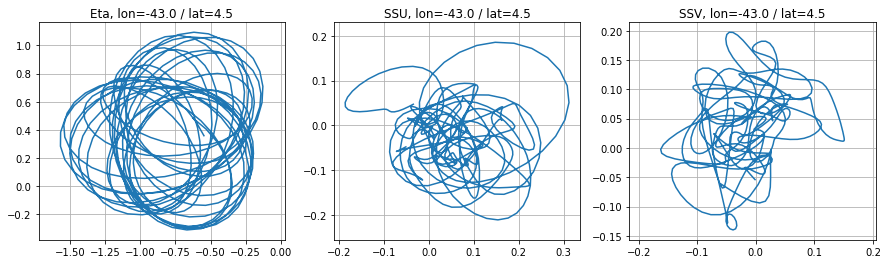

In [87]:
lon, lat = -43, 4.5 # amazonian shelf
_ds = ds.isel(get_index(lon, lat, ds)) 

fig, axes = plt.subplots(1,3, figsize=(15,4))

for v, ax in zip(V, axes):
    ax.plot(np.real(_ds[v]), np.imag(_ds[v]))
    ax.set_title(v+", lon={:.1f} / lat={:.1f}".format(lon, lat))
    ax.axis('equal')
    ax.grid()

---

## deep, shallow

In [46]:
_ds = ds.drop_vars(V)

deep = (_ds.where(mask_deep)*_ds.rA/A_deep).mean(["face", "i", "j"]).persist()

# wait that deep has been computed and loaded, memory usage is a bit high otherwise

In [47]:
shallow = (_ds.where(mask_shallow)*_ds.rA/A_shallow).mean(["face", "i", "j"]).persist()

### deep

Text(0, 0.5, 'sqrt(u^2+v^2)')

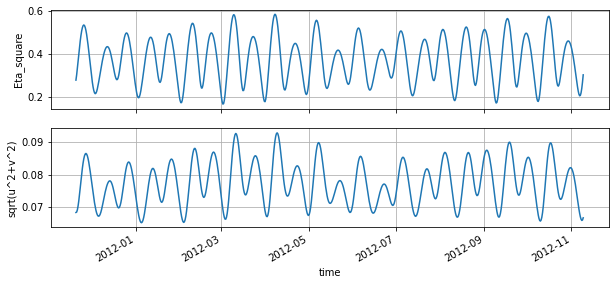

In [51]:
_ds = deep

fig, axes = plt.subplots(2,1, figsize=(10, 4))

ax = axes[0]
np.sqrt(_ds["Eta_square"]).plot(ax=ax)
ax.set_xticklabels([])
ax.grid()
ax.set_xlabel("")

ax = axes[1]
np.sqrt(_ds["SSU_square"]+_ds["SSV_square"]).plot(ax=ax)
#_ds["SSV"].plot(ax=ax)
#ax.set_xticklabels([])
ax.grid()
ax.set_ylabel("sqrt(u^2+v^2)")

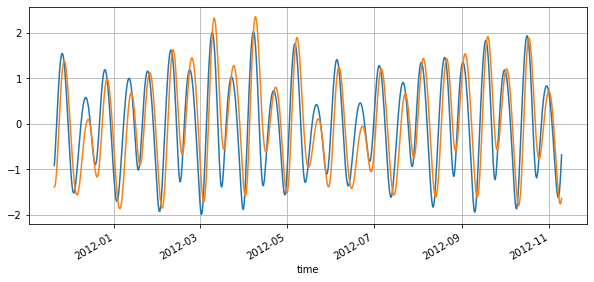

In [52]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))

_eta = np.sqrt(_ds["Eta_square"])

((_eta-_eta.mean())/_eta.std() ).plot(ax=ax, label="Eta")

_u = np.sqrt(_ds["SSU_square"]+_ds["SSV_square"])
((_u-_u.mean())/_u.std() ).plot(ax=ax, label="sqrt(u^2+v^2)")
ax.grid()

### shallow

Text(0, 0.5, 'sqrt(u^2+v^2)')

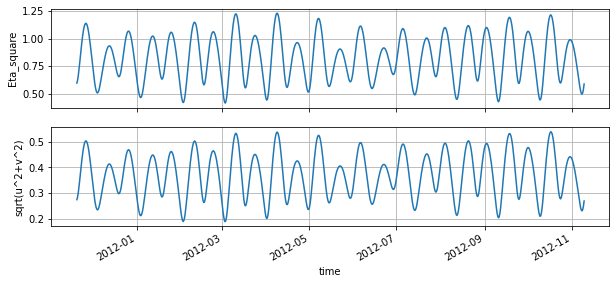

In [54]:
_ds = shallow

fig, axes = plt.subplots(2,1, figsize=(10, 4))

ax = axes[0]
np.sqrt(_ds["Eta_square"]).plot(ax=ax)
ax.set_xticklabels([])
ax.grid()
ax.set_xlabel("")

ax = axes[1]
np.sqrt(_ds["SSU_square"]+_ds["SSV_square"]).plot(ax=ax)
#_ds["SSV"].plot(ax=ax)
#ax.set_xticklabels([])
ax.grid()
ax.set_ylabel("sqrt(u^2+v^2)")

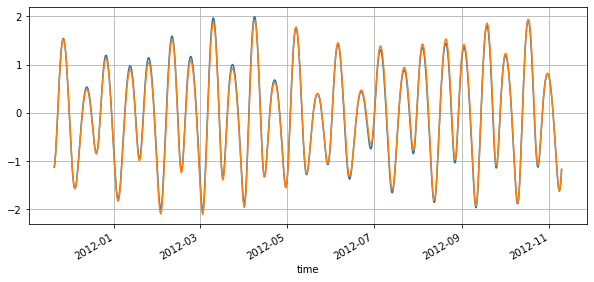

In [55]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))

_eta = np.sqrt(_ds["Eta_square"])

((_eta-_eta.mean())/_eta.std() ).plot(ax=ax, label="Eta")

_u = np.sqrt(_ds["SSU_square"]+_ds["SSV_square"])
((_u-_u.mean())/_u.std() ).plot(ax=ax, label="sqrt(u^2+v^2)")
ax.grid()

### zonal average

!!! rerun !!!

In [46]:
from xhistogram.xarray import histogram

In [52]:
dl = 1.
lat_bins = np.arange(-60, 60, dl)

def bin_average(ds, V=None):

    ds["lat_3d"] = 0*ds.face+ds.YC
    ds["lat_4d"] = 0*ds.SSU+ds.YC    
    
    N = histogram(ds.lat_3d.rename("lat"), bins=[lat_bins], 
                  dim=["i", "j", "face"]
                 ).persist()

    E = {}
    if V is None:
        V = ds
    for v in V:
        _E = histogram(ds.lat_4d.rename("lat"), bins=[lat_bins], 
                      weights=ds[v],
                      dim=["i", "j", "face"]
                     )
        E[v] = (_E/N).rename(v).persist()

    return E, N

In [53]:
deep_bin, deep_N = bin_average(ds.where(mask_deep))

In [ ]:
deep_bin["Eta_square"].plot(x="time", figsize=(10, 5))

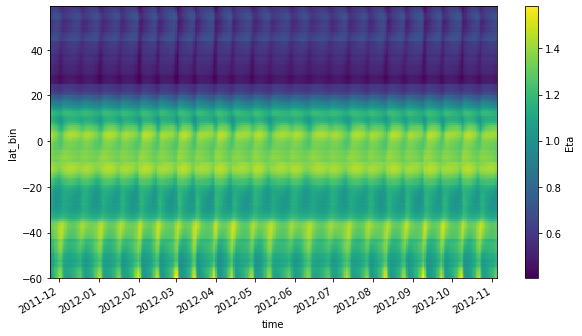

In [34]:
(deep_bin["Eta"]/deep_bin["Eta"].mean("lat_bin")).plot(x="time", figsize=(10, 5))

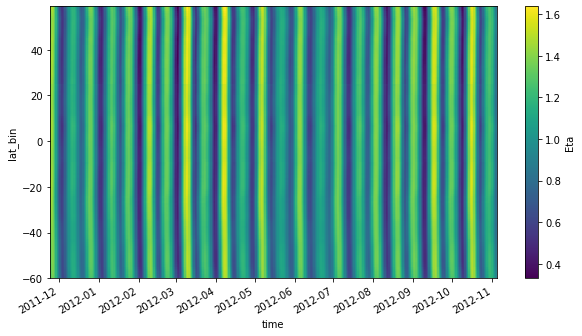

In [36]:
(deep_bin["Eta"]/deep_bin["Eta"].mean("time")).plot(x="time", figsize=(10, 5))

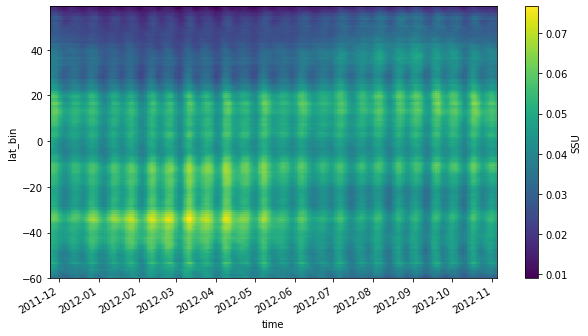

In [26]:
deep_bin["SSU"].plot(x="time", figsize=(10, 5))

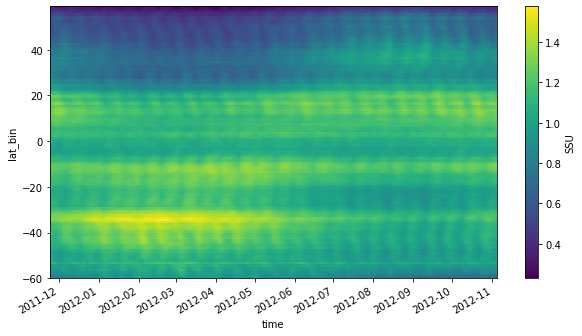

In [35]:
(deep_bin["SSU"]/deep_bin["SSU"].mean("lat_bin")).plot(x="time", figsize=(10, 5))

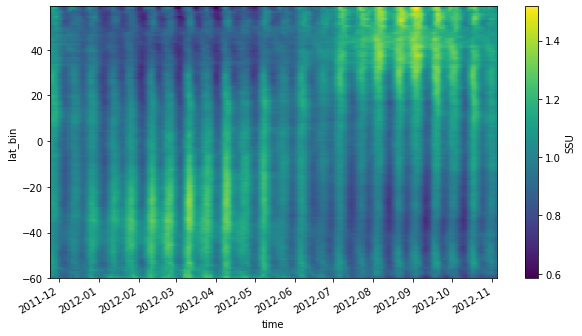

In [37]:
(deep_bin["SSU"]/deep_bin["SSU"].mean("time")).plot(x="time", figsize=(10, 5))

---

### make movie

[deepak code](https://discourse.pangeo.io/t/using-dask-to-parallelize-plotting/1179/5?u=apatlpo)


In [33]:
v = "Eta"
#v = "SSU"

In [34]:
_da = abs(ds[v])

#_da = _da.isel(time=slice(0, None, 2))
#_da = _da.isel(time=slice(0, 10, 2)) # tmp
_da = _da.isel(i=slice(0, None, 2), j=slice(0, None, 2))

_da = _da.chunk(dict(face=-1, j=-1, i=-1, time=1)).persist()

In [35]:
from dask import delayed

figdir = os.path.join(ut.scratch, "figs/")

def genfig(da, pretty=True, overwrite=True, **kwargs):
    
    region = "global"
    
    v = da.name

    time = pd.to_datetime(da["time"].values)
    figname = os.path.join(figdir, 
                           "{}_{}_{}.png".format(v, region, time.strftime("%Y%m%d%H"))
                          )
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = "{} {}".format(v, time.strftime("%Y-%m-%d %Hh"))
        pkwargs = dict(region=region,
                       colorbar=True, colorbar_kwargs=dict(shrink=0.6),
                       title=title, savefig=figname,
                       offline=True,
                       figsize=(15, 8)
                      )
        pkwargs.update(**kwargs)
        fac = pl.plot_pretty(da, **pkwargs)
        
        # add phase?

        #
        m = time
    else:
        m = 0
    return m

In [36]:
kw = dict(Eta=dict(vmin=0, vmax=2, cmap="magma"),
          SSU=dict(vmin=0, vmax=.3, cmap="magma"),
         )

I = range(len(_da["time"]))
#I = range(10) # debug

values = [delayed(genfig)(_da.isel(time=i), **kw[v]) for i in I]

In [37]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 2min 8s, sys: 4.07 s, total: 2min 12s
Wall time: 2min 17s


In [ ]:
figdir = os.path.join(ut.scratch, "figs/")

def save_image(block, **kwargs):
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    #from mitequinox.plot import plot_pretty

    plt.switch_backend("agg")
    
    if sum(block.shape) > 0:
        # workaround 1:
        # xarray passes a zero shaped array to infer what this function returns. 
        # we can"t run plot, so avoid doing that
        f = plt.figure()
        ax = f.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()}, squeeze=True)

        #fac = plot_pretty(block,
        #            colorbar=True, colorbar_kwargs=dict(shrink=0.4),
        #            savefig=figdir+"{}.png".format(block.time.values[0]),
        #            **kwargs
        #           )
        
        # xarray plotting goodness is available here!
        block.isel(face=1).plot(ax=ax, robust=True, vmin=0, vmax=1,
                   cbar_kwargs={"extend": "both"})
   
        # on pangeo.io, this will need some tweaking to work with gcsfs.
        # haven"t tried that. On cheyenne, it works beautifully.
        f.savefig(figdir+"{}.png".format(block.time.values[0]), dpi=180)
        #plt.close(fac["fig"])

    # workaround 2:
    # map_blocks expects to receive an xarray thing back.
    # Just send back one value. If we send back "block" that"s like computing the whole dataset!
    return block["time"]
    

# I want to animate in time, so chunk so that there is 1 block per timestep.
tasks = ds["Eta"].map_blocks(save_image, kwargs=dict(vmin=0., vmax=1)).compute()
#tasks.compute()

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [9]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 